<a href="https://colab.research.google.com/github/neriiacopo/IAAC-II-CLIPStudies-Masterclass/blob/main/IAACII_CLIP_Studies_Attention_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### *CLIP Studies @ ETSAM - November 2024*
#**WHERE - Saliency Map with CLIP**
*Iacopo Neri (iacopo.neri@uzh.ch) -- IAAC Faculty & MaCT Computational Lead (Spain) // Digital Visual Studies, University of Zurich (Switzerland)*

*Darìo Negueruela del Castillo (iacopo.neri@uzh.ch) -- Digital Visual Studies, University of Zurich (Switzerland)*

The following script takes extensive inspiration from the original [Language-Visual Saliency with CLIP and OpenVINO™](https://docs.openvino.ai/2023.2/notebooks/232-clip-language-saliency-map-with-output.html)

# Import libraries

In [1]:
from pathlib import Path
from typing import Tuple, Union, Optional
from urllib.request import urlretrieve

from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import tqdm
from PIL import Image
from transformers import CLIPModel, CLIPProcessor

import requests
from io import BytesIO


# Import Model

In [2]:
model_checkpoint = "openai/clip-vit-base-patch16"

model = CLIPModel.from_pretrained(model_checkpoint).eval()
processor = CLIPProcessor.from_pretrained(model_checkpoint)

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

# General functions

In [3]:
def get_random_crop_params(
    image_height: int, image_width: int, min_crop_size: int
) -> Tuple[int, int, int, int]:
    crop_size = np.random.randint(min_crop_size, min(image_height, image_width))
    x = np.random.randint(image_width - crop_size + 1)
    y = np.random.randint(image_height - crop_size + 1)
    return x, y, crop_size


def get_cropped_image(
    im_tensor: np.array, x: int, y: int, crop_size: int
) -> np.array:
    return im_tensor[
        y : y + crop_size,
        x : x + crop_size,
        ...
    ]


def update_saliency_map(
    saliency_map: np.array, similarity: float, x: int, y: int, crop_size: int
) -> None:
    saliency_map[
        y : y + crop_size,
        x : x + crop_size,
    ] += similarity


def cosine_similarity(
    one: Union[np.ndarray, torch.Tensor], other: Union[np.ndarray, torch.Tensor]
) -> Union[np.ndarray, torch.Tensor]:
    return one @ other.T / (np.linalg.norm(one) * np.linalg.norm(other))


def plot_saliency_map(image_tensor: np.ndarray, saliency_map: np.ndarray, query: Optional[str]) -> None:
    fig = plt.figure(dpi=300)
    plt.imshow(image_tensor)
    plt.imshow(
        saliency_map,
        norm=colors.TwoSlopeNorm(vcenter=0),
        cmap="RdYlBu_r",
        alpha=0.5,  # make saliency map trasparent to see original picture
    )
    plt.colorbar(location="bottom")

    if query:
        plt.title(f'Query: "{query}"')
    plt.axis("off")

    return fig

# Saliency map evaluation

  0%|          | 0/100 [00:00<?, ?it/s]

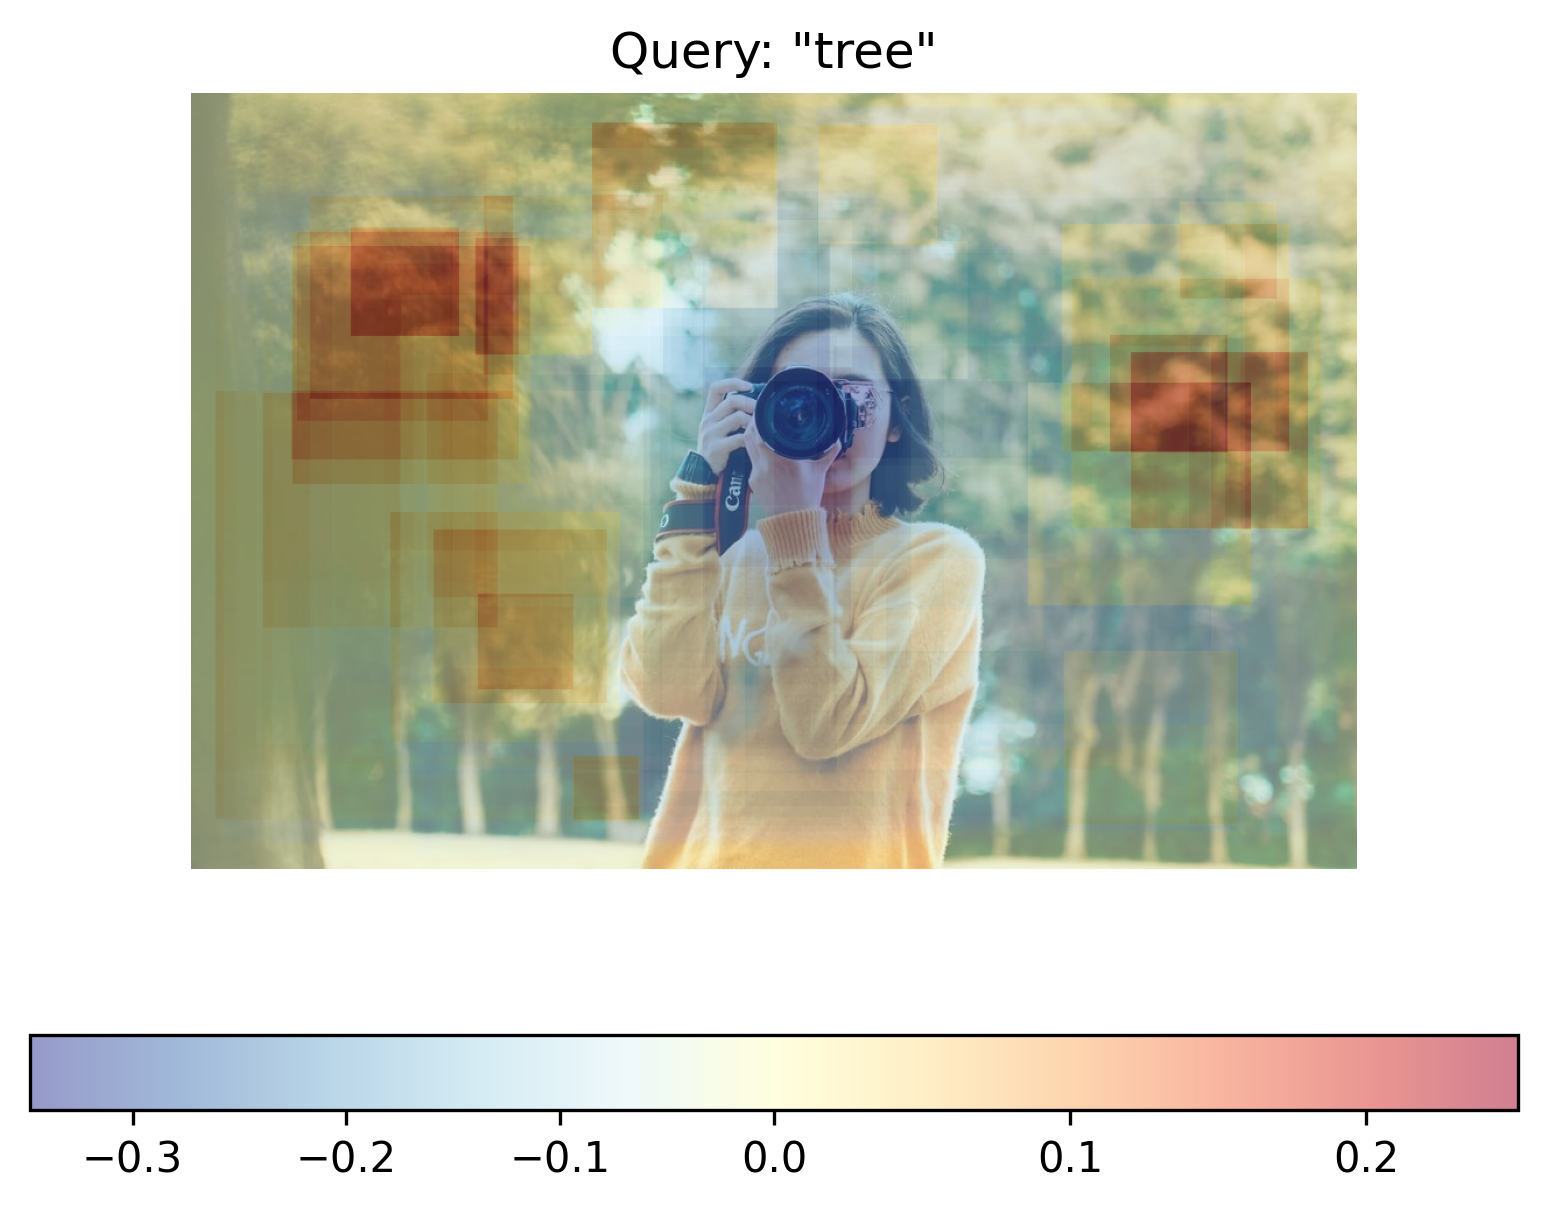

In [6]:
#@title Settings 🔬🎨

url = "https://buffer.com/cdn-cgi/image/w=1000,fit=contain,q=90,f=auto/library/content/images/size/w1200/2023/10/free-images.jpg" #@param {type:"string"}
query = "tree" #@param {type:"string"}

n_iters = 100  #@param {type:"number"}
min_crop_size = 50 #@param {type:"number"}

# Import data
response = requests.get(url)
image = Image.open(BytesIO(response.content))
im_tensor = np.array(image)
x_dim, y_dim = image.size

# Preprocess inputs

inputs = processor(text=[query], images=[im_tensor], return_tensors="pt")
with torch.no_grad():
    results = model(**inputs)
text_embeds = results.text_embeds  # save text embeddings to use them later

# Evaluate similarity
initial_similarity = cosine_similarity(text_embeds, results.image_embeds).item()
saliency_map = np.zeros((y_dim, x_dim))

for _ in tqdm.notebook.tqdm(range(n_iters)):
    x, y, crop_size = get_random_crop_params(y_dim, x_dim, min_crop_size)
    im_crop = get_cropped_image(im_tensor, x, y, crop_size)

    image_inputs = processor(images=[im_crop], return_tensors="pt")  # crop preprocessing
    with torch.no_grad():
        image_embeds = model.get_image_features(**image_inputs)  # calculate image embeddings only

    similarity = cosine_similarity(text_embeds, image_embeds).item() - initial_similarity
    update_saliency_map(saliency_map, similarity, x, y, crop_size)

# Plot result
plot_saliency_map(im_tensor, saliency_map, query);